July 2024 was an exceptional month in terms of irradiance anomalies in North America. In one of [Solcast's weekly PVMag publications](https://www.pv-magazine.com/2024/08/02/aerosols-from-wildfires-slash-north-american-solar-production/) we have highlighted how irradiance was severely impacted in the north west of  the continent by aerosols deriving from the raging Canadian wildfires.

In addition to the reduced irradiance from the aerosol's absorption, another factor to take into account into the overall impact of these aerosols on solar generation is dust soiling as the accumulated particles block or scatter incident light, further reducing power output. The Solcast API allows the user to specify the dust-derived losses:
- in the `rooftop_pv_power` the `loss_factor` parameter effectively captures the non-temperature loss effects on the nameplate rating of the PV system, including inefficiency and soiling
- in the `advanced_pv_power` the `apply_dust_soiling` is a user-override for the dust soiling average computed by Solcast. If you specify this parameter in your API call, the API will replace the site's annual or monthly average dust soiling values with the value you specify in your API call.E.g. if you specify a 0.7 dust soiling, your returned power will be reduced by 70%.


In this tutorial we are going to see how we can model dust soiling using the `pvlib` python toolbox and Solcast's weather data while trying to see the impact of these aerosols on a site that may have been affected by these wildfires.

First off, install `pvlib`.

In [1]:
#!pip install pvlib folium

In [2]:
import os
import datetime
import matplotlib.pyplot as plt
import pandas as pd
import folium
from pvlib.iotools import solcast
from pvlib.soiling import kimber

import warnings
warnings.filterwarnings("ignore")

We can use one of [Solcast's unmetered locations](https://docs.solcast.com.au/#unmetered-locations) so you don't use up your requests. We choose Fort Peck from SURFRAD sites.

In [3]:
# Surfrad's Fort Peck
latitude, longitude = 48.30783,	-105.1017
start, end = "2024-05-01T04:00:00", "2024-08-01T04:00:00" 

map = folium.Map(location=[latitude, longitude], zoom_start=5) 
folium.Marker([latitude, longitude], popup="Fort Peck").add_to(map)
map

now let's use `pvlib.iotools.solcast` to fetch the hourly precipitation rate.

In [4]:
rainfall_data = solcast.get_solcast_historic(
    latitude, longitude, 
    start=start, end=end, 
    api_key=os.getenv('SOLCAST_API_KEY'), 
    output_parameters=['precipitation_rate'],
    period="PT1H"
)[0]

rainfall_data.head()

,precipitation_rate
period_mid,
2024-05-01 04:30:00+00:00,0.0
2024-05-01 05:30:00+00:00,0.0
2024-05-01 06:30:00+00:00,0.0
2024-05-01 07:30:00+00:00,0.0
2024-05-01 08:30:00+00:00,0.0


To assist in the interpretation of results, we create a new column `accumulated_rainfall` with the daily total rainfall, i.e. the total rainfall in the preceding 24h. This matches what the Kimber algorithm does: when this accumulation reaches the cleaning threshold, the soiling rate returns to 0.

We also set up a plotting function to superimpose the accumulation on the soiling rate results.

In [5]:
# the local timezone is UTC - 4 hours
rainfall_data.index = rainfall_data.index - pd.Timedelta(hours=4)

rainfall_data['accumulated_rainfall'] = rainfall_data.rolling(24, closed='right').sum()

In [6]:
def plot(
    time_labels: pd.DatetimeIndex, 
    precip_rate: pd.Series, 
    precip_daily: pd.Series, 
    soiling: pd.Series, 
    threshold: int=15
):
    """function that plots the precipitation accumulation alongside soiling rate.

    Args:
        time_labels: the datetime values to use for the x-axis
        precip_rate: the hourly precipitation rate values in mm/h
        precip_daily: the daily sum of precipitation in mm
        soiling: soiling rate
        threshold: amount of daily rainfall required to clean the panels.
    """
    fig, ax1 = plt.subplots(figsize=(12,5))
    
    # line plot showing the soiling loss
    ax1.plot(time_labels, soiling.values*100, linestyle=':', label='soiling loss', color='orange')
    ax1.set_ylabel("energy loss fraction (%)", color='orange')

    # secondary axis for the rainfall
    ax2 = ax1.twinx()
    
    # horizontal line for the threshold
    ax2.hlines(y=threshold, xmin=time_labels.min(), xmax=time_labels.max(), linestyle='--', label='cleaning threshold')
    
    # bar plot of the daily sum of the rainfall
    ax2.plot(time_labels, precip_daily, label="daily rain accumulation", alpha=0.5)
    ax2.plot(time_labels, precip_rate, label="precipitation rate", color='blue', linewidth=0.5)
    ax2.set_ylabel("precipitation (mm)", color='blue')
    
    fig.legend()
    fig.show()

Once we have the rainfall data we can use `pvlib.soiling.kimber` to compute the energy loss from soiling, starting from the rainfall obtained and a daily soiling loss rate. More information regarding the algorithm and the parameters can be found in [pvlib's documentation](https://pvlib-python.readthedocs.io/en/stable/reference/generated/pvlib.soiling.kimber.html).

average soiling loss: 0.025438887001810104


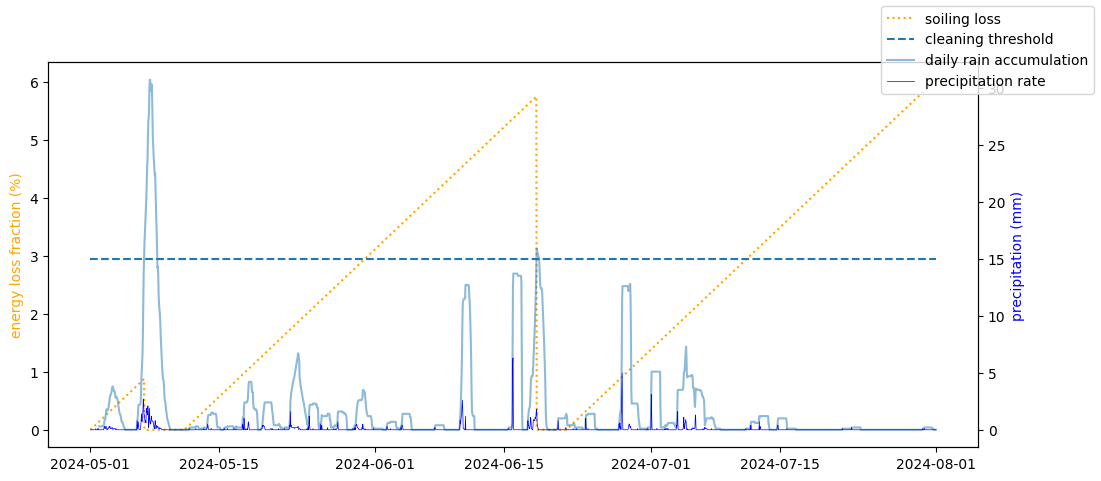

In [7]:
soiling = kimber(
    rainfall_data.precipitation_rate, 
    cleaning_threshold=15.0, 
    grace_period=3, # Number of days after a rainfall event 
    # when it’s assumed the ground is damp, and so it’s assumed there is no soiling. 
    soiling_loss_rate=0.0015 # Fraction of energy lost due to one day of soiling.
)

df = pd.concat([rainfall_data, soiling], axis=1)

f = plot(df.index, df.precipitation_rate, df.accumulated_rainfall, df.soiling)

print(f"average soiling loss: {df.soiling.mean()}") 

As we can see, May and July have rarely experienced enough rainfall to surpass our rainfall accumulation threshold and therefore soiling losses increase throughout the month, reaching a rate as high as ~6% if no cleaning is applied. Soiling rate averages 3% across the period. Lowering the cleaning threshold, e.g. for more tilted panels, will give us a lower rate: with 10mm of rain set as the threshold, the average soiling rate is 1.5%.

average soiling loss: 0.01534742980072379


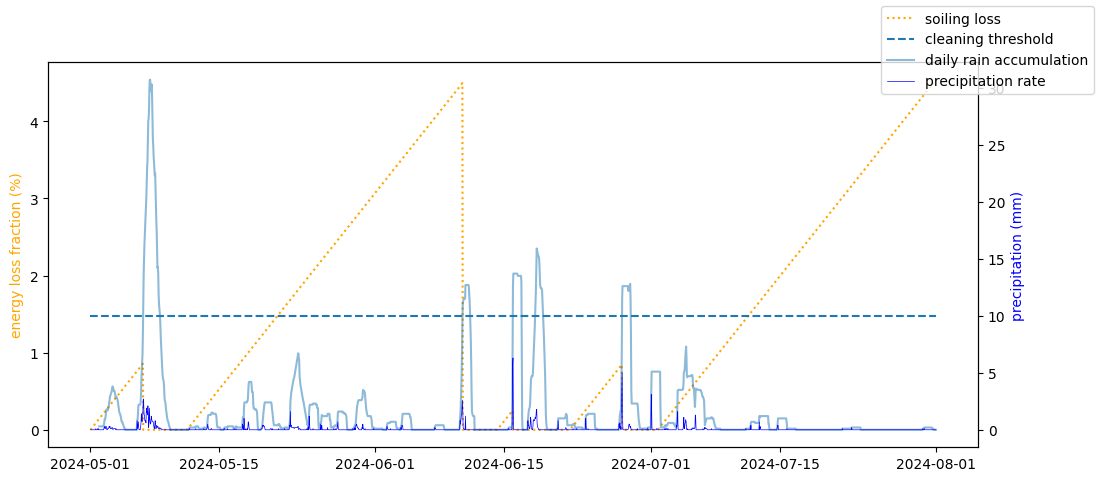

In [8]:
soiling = kimber(
    rainfall_data.precipitation_rate, 
    cleaning_threshold=10.0, 
    grace_period=3, 
    soiling_loss_rate=0.0015
)

df = pd.concat([rainfall_data, soiling], axis=1)

f = plot(df.index, df.precipitation_rate, df.accumulated_rainfall, df.soiling, threshold=10)

print(f"average soiling loss: {df.soiling.mean()}") 

The Kimber implementation in `pvlib` allows specification of `manual_wash_dates`. Below we set a biweekly schedule on which our panels will be cleaned, bringing the soiling loss back to zero without starting a "grace period":

average soiling loss: 0.0077790421195647564


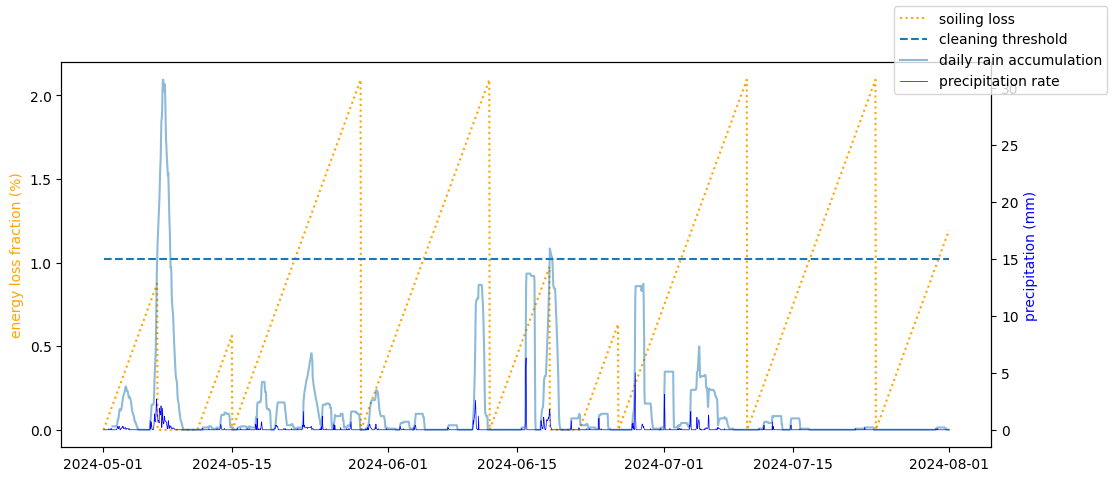

In [9]:
soiling = kimber(
    rainfall_data.precipitation_rate, 
    cleaning_threshold=15.0,
    grace_period=3,
    soiling_loss_rate=0.0015, 
    manual_wash_dates=pd.date_range("2024-05-15T00:30:00", end, freq="14D")
)

df = pd.concat([rainfall_data, soiling], axis=1)

plot(df.index, df.precipitation_rate, df.accumulated_rainfall, df.soiling)

print(f"average soiling loss: {df.soiling.mean()}") 

The result is that, given our soiling rate assumptions, the soiling losses are 1/3 or less of the losses that this site would have seen during this period if a biweekly cleaning schedule was to be implemented.

You could now take a look at the example `2.1 PVLib - ModelChain with Solcast weather data.ipynb` where we show calculating AC power with `pvlib` and you could model the power as a function of the different soiling losses.